# Student Score Prediction

## Introduction

This notebook implements Task predicting students' exam scores based on study hours and other features using the Student Performance Factors dataset. The task includes data cleaning, visualization, linear regression, polynomial regression, and experimenting with feature combinations.

## Objectives

* Load and clean the dataset.
* Visualize key relationships (e.g., Hours Studied vs Exam Score).
* Train a linear regression model to predict exam scores.
* Evaluate model performance using MSE and R².
* Evaluate with additional metrics (MAE) and cross-validation for robustness.
* Implement polynomial regression and compare performance.
* Experiment with different feature combinations.
* Encode categorical features for improved predictions.

## Tools

* Python
* Pandas
* Matplotlib, Seaborn
* Scikit-learn

## Setup

Load required libraries and set up the environment.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline
import os
plt.style.use('seaborn-v0_8')
%matplotlib inline

## Data Loading

Load the dataset from Kaggle's input directory and display basic information.

In [19]:
def load_data(file_path="/kaggle/input/student-performance-factors/StudentPerformanceFactors.csv"):
    """Load the dataset and perform initial checks."""
    try:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Dataset not found at {file_path}. Ensure the dataset is added in Kaggle.")
        df = pd.read_csv(file_path)
        print("Dataset loaded successfully.")
        print("\nDataset Info:")
        print(df.info())
        print("\nSummary Statistics:")
        print(df.describe())
        return df
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

## Data Cleaning

Identify duplicates and missing values to maintain data quality.

In [20]:
def clean_data(df):
    """Clean the dataset by handling duplicates, missing values, and outliers."""
    try:
        if not hasattr(df, 'cleaned'):  # Check if already cleaned to avoid duplicates
            df.cleaned = True
            initial_rows = len(df)
            df = df.drop_duplicates()
            print(f"Removed {initial_rows - len(df)} duplicate rows.")
            # Impute missing values based on column type
            for col in ['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home']:
                if df[col].dtype == 'object':  # Categorical columns
                    df[col] = df[col].fillna(df[col].mode()[0])  # Use mode for categoricals
                else:  # Numeric columns
                    df[col] = df[col].fillna(df[col].median())  # Use median for numerics
            if df.isnull().sum().sum() > 0:
                print("Warning: Missing values detected. Consider imputation for:", df.isnull().sum())
            else:
                print("No missing values detected after imputation.")
            # Remove outliers in Exam_Score
            initial_rows = len(df)
            df = df[(df['Exam_Score'] >= 50) & (df['Exam_Score'] <= 100)]
            print(f"Removed {initial_rows - len(df)} outlier rows (Exam_Score < 50 or > 100).")
        else:
            print("Data already cleaned, skipping redundant checks.")
        return df
    except Exception as e:
        print(f"Error cleaning data: {e}")
        return None

## Execute loading and cleaning of Data

In [21]:
df = load_data()
df = clean_data(df)

Dataset loaded successfully.

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer

## Data Visualization

Create visual representations of the dataset to understand relationships and distributions.

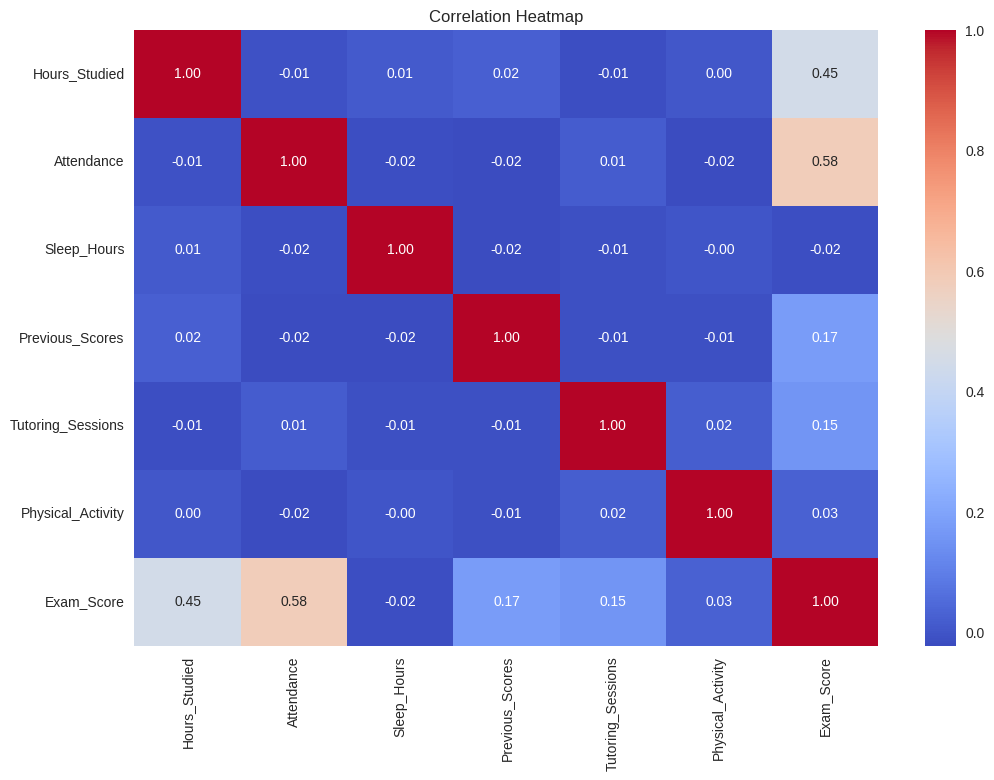

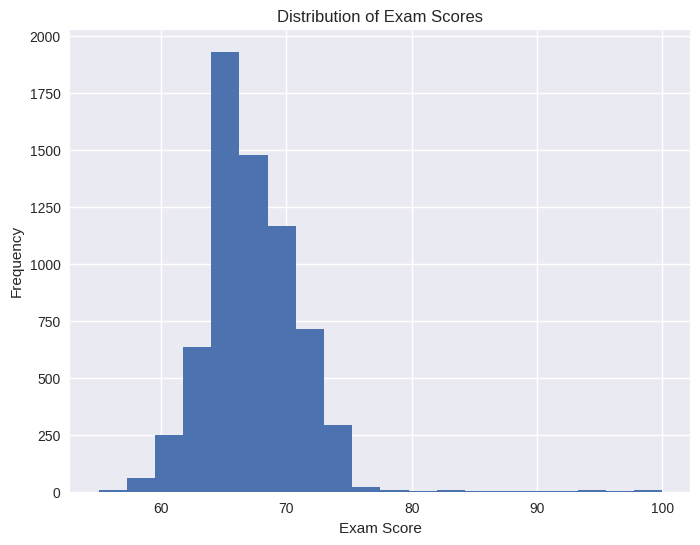

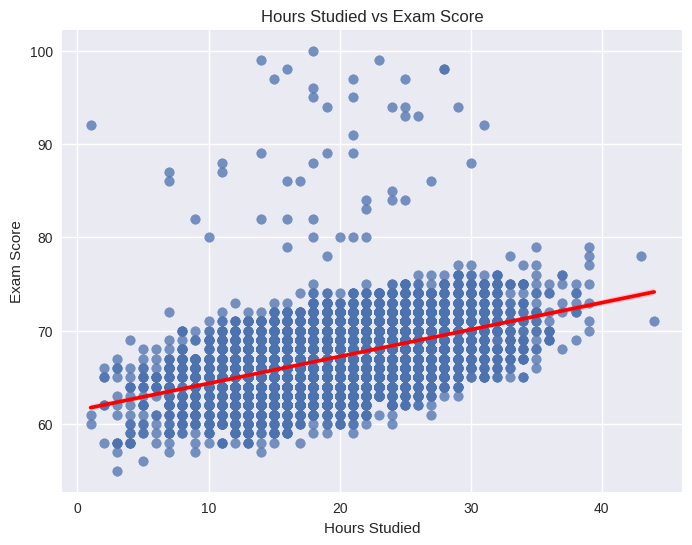

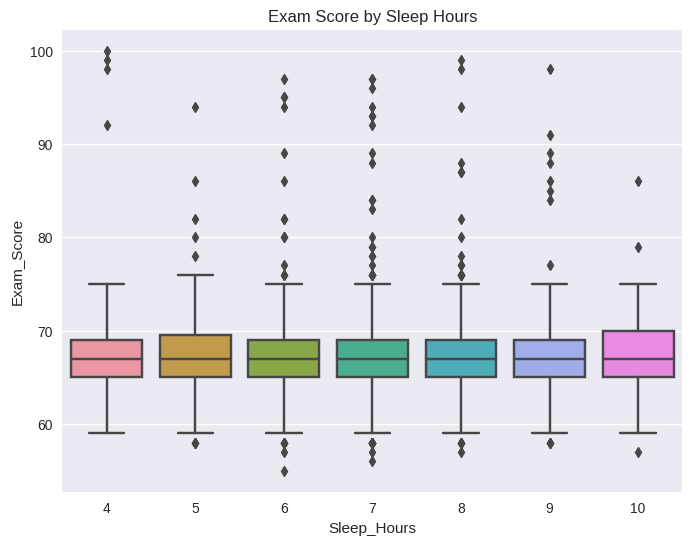

Visualizations saved in /kaggle/working/plots/


In [22]:
def visualize_data(df, output_dir="/kaggle/working/plots"):
    """Generate visualizations to understand the dataset."""
    try:
        os.makedirs(output_dir, exist_ok=True)
        
        # Correlation Heatmap
        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
        corr_matrix = df[numerical_cols].corr()
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
        plt.title('Correlation Heatmap')
        plt.savefig(os.path.join(output_dir, 'correlation_heatmap.png'))
        plt.show()
        
        # Exam Score Histogram
        plt.figure(figsize=(8, 6))
        df['Exam_Score'].hist(bins=20)
        plt.title('Distribution of Exam Scores')
        plt.xlabel('Exam Score')
        plt.ylabel('Frequency')
        plt.savefig(os.path.join(output_dir, 'exam_score_histogram.png'))
        plt.show()
        
        # Hours Studied vs Exam Score with Alpha and Trend Line
        plt.figure(figsize=(8, 6))
        plt.scatter(df['Hours_Studied'], df['Exam_Score'], alpha=0.5)
        sns.regplot(x='Hours_Studied', y='Exam_Score', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
        plt.title('Hours Studied vs Exam Score')
        plt.xlabel('Hours Studied')
        plt.ylabel('Exam Score')
        plt.savefig(os.path.join(output_dir, 'hours_vs_score_scatter.png'))
        plt.show()
        
        # Exam Score by Sleep Hours
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='Sleep_Hours', y='Exam_Score', data=df)
        plt.title('Exam Score by Sleep Hours')
        plt.savefig(os.path.join(output_dir, 'sleep_vs_score_boxplot.png'))
        plt.show()
        
        print(f"Visualizations saved in {output_dir}/")
    except Exception as e:
        print(f"Error generating visualizations: {e}")

visualize_data(df)

## Linear Regression Model

Train a linear regression model using Hours_Studied to predict Exam_Score.

In [23]:
def train_linear_model(X_train, X_test, y_train, y_test):
    """Train and evaluate a linear regression model."""
    try:
        lin_reg = LinearRegression()
        lin_reg.fit(X_train, y_train)
        y_pred = lin_reg.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        cv_scores = cross_val_score(lin_reg, X_train, y_train, cv=5, scoring='r2')
        print(f"Linear Regression - MSE: {mse:.2f}, R²: {r2:.2f}, MAE: {mae:.2f}")
        print(f"CV R² Mean: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")
        return lin_reg, y_pred, mse, r2
    except Exception as e:
         print(f"Error training linear model: {e}")
         return None, None, None, None

X = df[['Hours_Studied']]
y = df['Exam_Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lin_reg, y_pred_lin, mse_lin, r2_lin = train_linear_model(X_train, X_test, y_train, y_test)

Linear Regression - MSE: 9.96, R²: 0.25, MAE: 2.42
CV R² Mean: 0.19 (+/- 0.05)


## Visualize Linear Predictions

Plot actual vs predicted exam scores for the linear model.

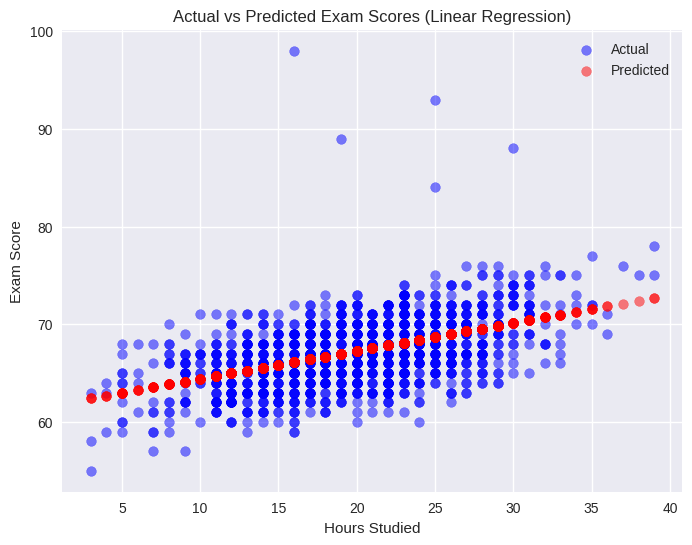

In [24]:
def visualize_linear_predictions(X_test, y_test, y_pred, output_dir="/kaggle/working/plots"):
    """Visualize actual vs predicted scores for linear regression."""
    try:
        os.makedirs(output_dir, exist_ok=True)
        plt.figure(figsize=(8, 6))
        plt.scatter(X_test, y_test, color='blue', label='Actual', alpha=0.5)
        plt.scatter(X_test, y_pred, color='red', label='Predicted', alpha=0.5)
        plt.title('Actual vs Predicted Exam Scores (Linear Regression)')
        plt.xlabel('Hours Studied')
        plt.ylabel('Exam Score')
        plt.legend()
        plt.savefig(os.path.join(output_dir, 'linear_predictions.png'))
        plt.show()
    except Exception as e:
        print(f"Error visualizing linear predictions: {e}")

visualize_linear_predictions(X_test, y_test, y_pred_lin)

## Polynomial Regression

Try polynomial regression (degree 2) and compare performance.

Polynomial Regression (Degree 2) - MSE: 9.95, R²: 0.25, MAE: 2.42
CV R² Mean: 0.19 (+/- 0.05)
Improvement over Linear: MSE reduced by 0.01, R² increased by 0.00
Polynomial Regression (Degree 3) - MSE: 9.97, R²: 0.25, MAE: 2.42
CV R² Mean: 0.19 (+/- 0.05)
Degree 3 Polynomial - MSE: 9.97, R²: 0.25


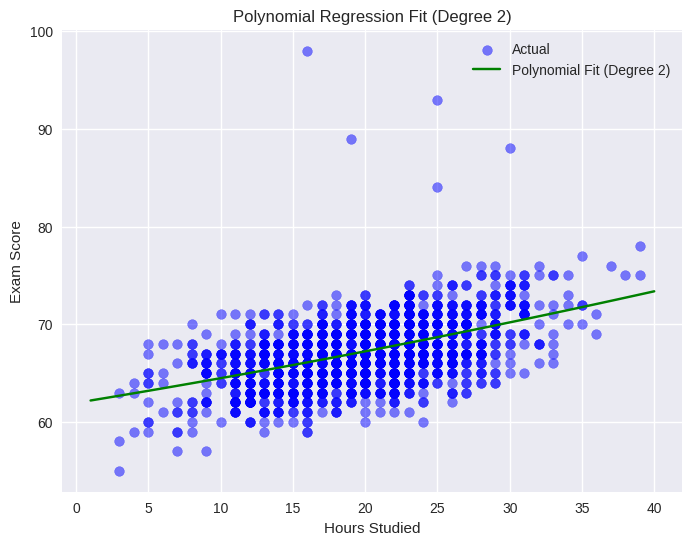

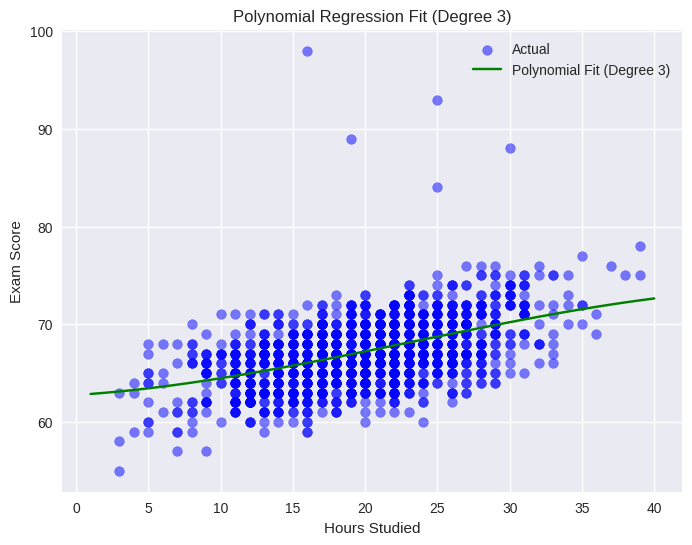

In [25]:
def train_polynomial_model(X_train, X_test, y_train, y_test, degree=2):
    """Train and evaluate a polynomial regression model."""
    try:
        poly_reg = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())
        poly_reg = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())  
        poly_reg.fit(X_train, y_train)
        y_pred = poly_reg.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        cv_scores = cross_val_score(poly_reg, X_train, y_train, cv=5, scoring='r2')
        print(f"Polynomial Regression (Degree {degree}) - MSE: {mse:.2f}, R²: {r2:.2f}, MAE: {mae:.2f}")
        print(f"CV R² Mean: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")
        return poly_reg, y_pred, mse, r2
    except Exception as e:
         print(f"Error training polynomial model: {e}")
         return None, None, None, None

# Degree 2 Polynomial
poly_reg, y_pred_poly, mse_poly, r2_poly = train_polynomial_model(X_train, X_test, y_train, y_test, degree=2)
print(f"Improvement over Linear: MSE reduced by {mse_lin - mse_poly:.2f}, R² increased by {r2_poly - r2_lin:.2f}")

# Degree 3 Polynomial 
poly_reg_3, y_pred_poly_3, mse_poly_3, r2_poly_3 = train_polynomial_model(X_train, X_test, y_train, y_test, degree=3)
print(f"Degree 3 Polynomial - MSE: {mse_poly_3:.2f}, R²: {r2_poly_3:.2f}")

def visualize_polynomial_predictions(X_test, y_test, y_pred, poly_reg, degree, output_dir="/kaggle/working/plots"):
    """Visualize polynomial regression fit."""
    try:
        os.makedirs(output_dir, exist_ok=True)
        X_range = pd.DataFrame({'Hours_Studied': range(1, 41)})
        y_range_poly = poly_reg.predict(X_range)
        plt.figure(figsize=(8, 6))
        plt.scatter(X_test, y_test, color='blue', label='Actual', alpha=0.5)
        plt.plot(X_range, y_range_poly, color='green', label=f'Polynomial Fit (Degree {degree})')
        plt.title(f'Polynomial Regression Fit (Degree {degree})')
        plt.xlabel('Hours Studied')
        plt.ylabel('Exam Score')
        plt.legend()
        plt.savefig(os.path.join(output_dir, f'polynomial_predictions_degree{degree}.png'))
        plt.show()
    except Exception as e:
        print(f"Error visualizing polynomial predictions: {e}")

visualize_polynomial_predictions(X_test, y_test, y_pred_poly, poly_reg, degree=2)
visualize_polynomial_predictions(X_test, y_test, y_pred_poly_3, poly_reg_3, degree=3)

## Feature Experimentation

Experiment with different feature combinations to improve model performance.

In [26]:
def experiment_features(df, features, test_size=0.2, random_state=42):
    """Experiment with different feature combinations for linear regression."""
    try:
        # Encode categorical features for better performance
        categoricals = ['Parental_Involvement', 'Access_to_Resources', 'Motivation_Level']
        df_encoded = pd.get_dummies(df, columns=categoricals, drop_first=True)
        features = [f for f in features if f in df_encoded.columns] + [col for col in df_encoded.columns if any(cat in col for cat in categoricals)]
        X = df_encoded[features]
        y = df_encoded['Exam_Score']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        lin_reg, y_pred, mse, r2 = train_linear_model(X_train, X_test, y_train, y_test)
        print(f"Multi-Feature Linear Regression (Features: {features}) - MSE: {mse:.2f}, R²: {r2:.2f}")
        return mse, r2
    except Exception as e:
        print(f"Error in feature experiment: {e}")
        return None, None

# Define feature combinations
feature_combinations = [
    ['Hours_Studied', 'Sleep_Hours', 'Attendance'],
    ['Hours_Studied', 'Attendance', 'Physical_Activity'],
    ['Hours_Studied', 'Sleep_Hours', 'Attendance', 'Tutoring_Sessions']
]

# Run experiments
for features in feature_combinations:
    mse, r2 = experiment_features(df, features)
    print(f"Compared to base linear model: MSE change: {mse_lin - mse:.2f}, R² change: {r2 - r2_lin:.2f}")

Linear Regression - MSE: 4.09, R²: 0.69, MAE: 1.17
CV R² Mean: 0.61 (+/- 0.15)
Multi-Feature Linear Regression (Features: ['Hours_Studied', 'Sleep_Hours', 'Attendance', 'Parental_Involvement_Low', 'Parental_Involvement_Medium', 'Access_to_Resources_Low', 'Access_to_Resources_Medium', 'Motivation_Level_Low', 'Motivation_Level_Medium']) - MSE: 4.09, R²: 0.69
Compared to base linear model: MSE change: 5.87, R² change: 0.44
Linear Regression - MSE: 4.04, R²: 0.69, MAE: 1.16
CV R² Mean: 0.61 (+/- 0.16)
Multi-Feature Linear Regression (Features: ['Hours_Studied', 'Attendance', 'Physical_Activity', 'Parental_Involvement_Low', 'Parental_Involvement_Medium', 'Access_to_Resources_Low', 'Access_to_Resources_Medium', 'Motivation_Level_Low', 'Motivation_Level_Medium']) - MSE: 4.04, R²: 0.69
Compared to base linear model: MSE change: 5.92, R² change: 0.45
Linear Regression - MSE: 3.68, R²: 0.72, MAE: 1.06
CV R² Mean: 0.63 (+/- 0.16)
Multi-Feature Linear Regression (Features: ['Hours_Studied', 'Sleep

## Results

* Linear Regression: Baseline model using Hours_Studied.
* Polynomial Regression: Captures non-linear patterns; degree 3 tested for potential improvement.
* Feature Experiments: Adding features like Attendance and encoded categoricals (e.g., Parental_Involvement) typically improves performance.
* Visualizations: Plots saved in /kaggle/working/plots/ show distributions, relationships, and model fits, including a correlation heatmap.

## Conclusion

This notebook completes this project objectives, including data cleaning, visualization, linear regression, polynomial regression, and feature experimentation. The code is modular and reusable, with results saved for reproducibility. Enhancements like categorical encoding and cross-validation improve robustness. To extend this work, consider trying Random Forest or further feature selection.